In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from pandas.core import datetools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics import utils

import warnings

warnings.filterwarnings('ignore')
get_ipython().magic('matplotlib inline')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
ntrain = train.shape[0]
ntest = test.shape[0]
# y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
# all_data.drop(['SalePrice'], axis=1, inplace=True)
print("All data size is {}".format(all_data.shape))

All data size is (2919, 81)


In [4]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning']= all_data["MSZoning"].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop('Utilities', axis=1)

all_data['Functional']= all_data["Functional"].fillna("Typ")

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data["Electrical"] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data["KitchenQual"]=all_data["KitchenQual"].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [5]:
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)
        
# #numerical
# corrmat = train.corr()
# k = 15
# cor_numerical_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 

In [6]:
# #categorical
# train_cat = train[categorical_features]
y_train_d = train['SalePrice']
# train_cat = pd.concat([y_train_d, train_cat], axis=1)

# def encode(frame, feature):
#     ordering = pd.DataFrame()
#     ordering['val'] = frame[feature].unique()
#     ordering.index = ordering.val
#     ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
#     ordering = ordering.sort_values('spmean')
#     ordering['ordering'] = range(1, ordering.shape[0]+1)
#     ordering = ordering['ordering'].to_dict()
    
#     for cat, o in ordering.items():
#         frame.loc[frame[feature] == cat, feature+'_E'] = o
    
# categorical_encoded = []
# for q in categorical_features:  
#     encode(train_cat, q)
#     categorical_encoded.append(q+'_E')


# corrmat2 = train_cat.corr()
# k = 6
# cor_categorical_cols = corrmat2.nlargest(k, 'SalePrice')['SalePrice'].index 

In [7]:
train = all_data[:ntrain]
test = all_data[ntrain:]

train = sm.add_constant(train)
train.tail()

,const,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1455,1.0,953,694,0,None,3,1Fam,TA,No,0.0,...,175000.0,WD,0,Pave,7,953.0,0,1999,2000,2007
1456,1.0,2073,0,0,None,3,1Fam,TA,No,790.0,...,210000.0,WD,0,Pave,7,1542.0,349,1978,1988,2010
1457,1.0,1188,1152,0,None,4,1Fam,Gd,No,275.0,...,266500.0,WD,0,Pave,9,1152.0,0,1941,2006,2010
1458,1.0,1078,0,0,None,2,1Fam,TA,Mn,49.0,...,142125.0,WD,0,Pave,5,1078.0,366,1950,1996,2010
1459,1.0,1256,0,0,None,3,1Fam,TA,No,830.0,...,147500.0,WD,0,Pave,6,1256.0,736,1965,1965,2008


In [8]:
train_n = train[numerical_features]
train_n = train_n.drop(['Id', 'SalePrice'], axis=1)
y_train_l = np.log1p(y_train_d)

model1_1 = sm.OLS(y_train_l, train_n)
result1_1 = model1_1.fit()

In [9]:
influence = result1_1.get_influence()

o_train = train[result1_1.resid_pearson > 2]
idx_r = np.where(result1_1.resid_pearson > 2)[0]

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y_train_l) - len(train_n.columns) - 1)
idx_c = np.where(cooks_d2 > fox_cr)[0]

resid_outliers = idx_r.tolist()
cooks_outliers = idx_c.tolist()

resid_cooks = list(set(resid_outliers) | set(cooks_outliers))

resid_outliers2 = [48, 142, 151, 178, 181, 218, 277, 378, 457, 473, 546, 669, 681, 688, 803, 807, 898, 970, 1046, 1059, 1065, 1075, 1170, 1181, 1182, 1423]
cooks_outliers2 = [30, 48, 88, 93, 125, 144, 153, 178, 197, 205, 218, 277, 335, 346, 375, 378, 410, 431, 457, 462, 495, 523, 546, 588, 608, 628, 632, 635, 658, 662, 664, 666, 691, 705, 710, 728, 738, 803, 807, 810, 812, 898, 907, 916, 942, 968, 970, 1030, 1048, 1059, 1062, 1068, 1080, 1170, 1181, 1182, 1211, 1216, 1298, 1324, 1337, 1386, 1415, 1423, 1432, 1437, 1453]

In [10]:
resid_cooks = [774, 1030, 8, 520, 523, 1298, 277, 1046, 1048, 30, 546, 803, 1059, 291, 807, 1065, 810, 812, 1068, 1324, 48, 1075, 1080, 1337, 588, 335, 88, 346, 608, 1386, 628, 632, 378, 635, 898, 907, 142, 1423, 1170, 658, 916, 662, 664, 153, 410, 666, 1432, 669, 1181, 1182, 1437, 681, 1453, 942, 431, 688, 178, 691, 181, 1211, 1216, 705, 197, 710, 968, 457, 970, 205, 462, 728, 473, 218, 738, 488, 495]

resid_cooks2 = [1030, 523, 1298, 277, 1046, 1048, 30, 546, 803, 1059, 1062, 807, 1065, 810, 812, 1068, 1324, 48, 1075, 1080, 1337, 588, 335, 88, 346, 93, 608, 1386, 628, 375, 632, 378, 635, 125, 898, 1415, 907, 142, 1423, 144, 1170, 658, 916, 662, 151, 664, 153, 410, 666, 1432, 669, 1181, 1182, 1437, 681, 1453, 942, 431, 688, 178, 691, 181, 1211, 1216, 705, 197, 710, 968, 457, 970, 205, 462, 728, 473, 218, 738, 495]

print(len(resid_cooks2))
print(len(resid_cooks))

print(set(resid_cooks) - set(resid_cooks2))
print(set(resid_outliers) - set(resid_outliers2))
print(set(cooks_outliers) - set(cooks_outliers2))

77
75
{291, 774, 8, 520, 488}
{774, 1030}
{8, 520, 291, 488}


In [32]:
IQR = [1024, 769, 1031, 1417, 523, 270, 1169, 1298, 1173, 1046, 1175, 533, 664, 408, 798, 1182, 1312, 1184, 803, 1061, 1190, 304, 1328, 178, 691, 185, 58, 825, 317, 1087, 961, 324, 197, 581, 583, 1350, 1353, 1228, 718, 1241, 608, 224, 231, 1386, 496, 1268, 118, 375, 1142, 635]
resid_cooks_IQR = [1024, 769, 1030, 1031, 523, 270, 1298, 277, 1046, 533, 1048, 1175, 30, 798, 1312, 546, 803, 1059, 1061, 1062, 807, 1065, 810, 812, 1068, 1324, 48, 304, 1328, 1075, 1080, 1337, 58, 825, 317, 1087, 1345, 324, 581, 1350, 583, 1353, 588, 335, 88, 346, 93, 608, 1386, 628, 118, 375, 632, 1142, 378, 635, 125, 898, 1415, 1417, 907, 142, 1423, 144, 1169, 1170, 658, 916, 1173, 662, 151, 664, 153, 410, 666, 1432, 669, 1181, 1182, 1437, 408, 1184, 1190, 681, 1453, 942, 431, 688, 178, 691, 181, 185, 1211, 1216, 705, 961, 197, 710, 968, 457, 970, 1228, 205, 462, 718, 728, 473, 218, 1241, 479, 224, 231, 495, 496, 1268]

In [11]:
# idx_t = np.where(result1_1.pvalues < 0.05)[0]
# tvalues = idx_t.tolist()

# x_train_cols = train_n.columns.tolist()

# select = []

# for i in tvalues:
#     select.append(x_train_cols[i])

# print(len(select), select)

# select_c = ['MSZoning', 'Neighborhood', 'Condition2', 'RoofMatl', 'Functional']

In [12]:
# train_s = train[select_1]

# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(train_s.values, i) for i in range(train_s.shape[1])]
# vif["features"] = train_s.columns
# vif

In [13]:
select_1 = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'YrSold']
select_2 = ['LotArea', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'OverallQual']
select_4 = ['GarageYrBlt', 'GarageCars', 'LotArea', 'YearBuilt', 'WoodDeckSF', 'MasVnrArea', 'KitchenAbvGr', 'TotalBsmtSF', 'BsmtFullBath', 'EnclosedPorch', 'ScreenPorch', 'GarageArea', 'BsmtFinSF1', 'Fireplaces', 'GrLivArea', 'FullBath', 'OverallQual', 'OverallCond']
select_5 = ['GarageCars', 'LotArea', 'YearBuilt', 'WoodDeckSF', 'MasVnrArea', 'KitchenAbvGr', 'TotalBsmtSF', 'BsmtFullBath', 'EnclosedPorch', 'ScreenPorch', 'BsmtFinSF1', 'Fireplaces', 'GrLivArea', 'FullBath', 'OverallQual', 'OverallCond']
select_3 = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']

print(len(select_1), len(select_2), len(select_3), len(select_4), len(select_5))

19 15 11 18 16


In [14]:
select_c1 = ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual']
select_c2 = ['MSZoning']
select_c3 = ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual', 'MSZoning']

In [15]:
train_c = train[select_c3]
train_c = train_c.drop(resid_outliers2)

train_n = train_n[select_1]
train_n = train_n.drop(resid_outliers2)

#추가 작업-변수 변환 
train_n = np.log1p(train_n)
x_train_new = train_n
x_train_new = pd.concat([train_n, train_c], axis=1)

y_train_new = y_train_d.drop(resid_outliers2)
y_train_new = np.log1p(y_train_new)

# #from_formula 사용 위해
train_new = pd.concat([y_train_new, x_train_new], axis=1)
train_new.tail()

,SalePrice,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,GrLivArea,...,GarageCars,WoodDeckSF,EnclosedPorch,ScreenPorch,YrSold,Neighborhood,ExterQual,KitchenQual,BsmtQual,MSZoning
1455,12.072547,4.110874,8.976894,1.945910,1.791759,7.600902,7.601402,0.000000,6.860664,7.407318,...,1.098612,0.000000,0.000000,0.0,7.604894,Gilbert,TA,TA,Gd,RL
1456,12.254868,3.044522,9.486152,1.945910,1.945910,7.590347,7.595387,6.673298,7.341484,7.637234,...,1.098612,5.857933,0.000000,0.0,7.606387,NWAmes,TA,TA,Gd,RL
1457,12.493133,4.262680,9.109746,2.079442,2.302585,7.571474,7.604396,5.620401,7.050123,7.758333,...,0.693147,0.000000,0.000000,0.0,7.606387,Crawfor,Ex,Gd,TA,RL
1458,11.864469,3.044522,9.181735,1.791759,1.945910,7.576097,7.599401,3.912023,6.983790,6.983790,...,0.693147,5.905362,4.727388,0.0,7.606387,NAmes,TA,Gd,TA,RL
1459,11.901590,3.044522,9.204121,1.791759,1.945910,7.583756,7.583756,6.722630,7.136483,7.136483,...,0.693147,6.602588,0.000000,0.0,7.605392,Edwards,Gd,TA,TA,RL


In [16]:
select_scale = []

for num in select_1:
    x = "scale(" + num + ")"
    select_scale.append(x)

formula = " + ".join(select_scale)
formula

'scale(MSSubClass) + scale(LotArea) + scale(OverallQual) + scale(OverallCond) + scale(YearBuilt) + scale(YearRemodAdd) + scale(BsmtFinSF1) + scale(TotalBsmtSF) + scale(GrLivArea) + scale(BsmtFullBath) + scale(FullBath) + scale(KitchenAbvGr) + scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(GarageCars) + scale(WoodDeckSF) + scale(EnclosedPorch) + scale(ScreenPorch) + scale(YrSold)'

In [17]:
c_categorical = []

for num in select_c3:
    x = "C(" + num + ")"
    c_categorical.append(x)

formula = " + ".join(c_categorical)
formula

'C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual) + C(MSZoning)'

In [18]:
model2_1 = sm.OLS.from_formula("SalePrice ~ scale(MSSubClass) + scale(LotArea) + scale(OverallQual) + scale(OverallCond) + scale(YearBuilt) + scale(YearRemodAdd) + scale(BsmtFinSF1) + scale(TotalBsmtSF) + scale(GrLivArea) + scale(BsmtFullBath) + scale(FullBath) + scale(KitchenAbvGr) + scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(GarageCars) + scale(WoodDeckSF) + scale(EnclosedPorch) + scale(ScreenPorch) + scale(YrSold) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual) + C(MSZoning)", data=train_new)
result2_1 = model2_1.fit()
print(result2_1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     249.6
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:34:45   Log-Likelihood:                 1054.2
No. Observations:                1434   AIC:                            -1992.
Df Residuals:                    1376   BIC:                            -1687.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [19]:
result2_2 = model2_1.fit_regularized(alpha=0.01, L1_wt=1)

In [20]:
print(result2_1.rsquared_adj)
print(result2_1.aic)
print(result2_1.bic)

0.9081663247314076
-1992.4760839892633
-1686.9191487620085


In [21]:
# #모형비교

# model_full = sm.OLS.from_formula("SalePrice ~ scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(OverallCond) + scale(GarageCars) + scale(BsmtFullBath) + scale(MasVnrArea) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual)", data=train_new)
# model_reduced = sm.OLS.from_formula("SalePrice ~ scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(OverallCond) + scale(GarageCars) + scale(BsmtFullBath) + scale(MasVnrArea) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual)", data=train_new)

# sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

In [22]:
sm.stats.anova_lm(result2_1, typ=2)

,sum_sq,df,F,PR(>F)
C(Neighborhood),2.429213,24.0,7.217074,6.585025e-23
C(ExterQual),0.048775,3.0,1.159258,3.240651e-01
C(KitchenQual),0.274805,3.0,6.531461,2.192614e-04
C(BsmtQual),0.786260,4.0,14.015649,3.264055e-11
C(MSZoning),0.792333,4.0,14.123897,2.670082e-11
scale(MSSubClass),0.026519,1.0,1.890854,1.693294e-01
scale(LotArea),0.844509,1.0,60.215868,1.647007e-14
scale(OverallQual),1.411830,1.0,100.667473,6.524115e-23
scale(OverallCond),2.558541,1.0,182.431245,3.948046e-39
scale(YearBuilt),0.792677,1.0,56.520112,9.984397e-14


In [23]:
train_new2 = train_new.drop(['SalePrice'], axis=1)

y_train_new2 = result2_1.predict(train_new2)
y_train_new2 = np.exp(y_train_new2)
y_train_new2 = np.array(y_train_new2)
print(y_train_new2)

[205400.14378775 203933.77375793 218191.69780545 ... 248551.59689222
 135437.52011376 140729.99168074]


In [24]:
y_train_new = np.array(y_train_new)
y_train_new = np.exp(y_train_new)
print(y_train_new)

[208501. 181501. 223501. ... 266501. 142126. 147501.]


In [25]:
sm.tools.eval_measures.rmse(y_train_new, y_train_new2, axis=0)

24928.177025833756

In [26]:
test_norm = sms.omni_normtest(result2_1.resid)
for xi in zip(['Chi^2', 'P-value'], test_norm):
    print("%-12s: %6.3f" % xi)

Chi^2       : 830.294
P-value     :  0.000


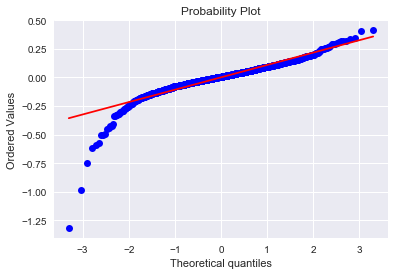

In [27]:
sp.stats.probplot(result2_1.resid, plot=plt)
plt.show()

In [28]:
test_new = test[select_1]
test_new = np.log1p(test_new)

test_new2 = test[select_c3]

test_new = pd.concat([test_new, test_new2], axis=1)
test_new.tail()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,GrLivArea,BsmtFullBath,...,GarageCars,WoodDeckSF,EnclosedPorch,ScreenPorch,YrSold,Neighborhood,ExterQual,KitchenQual,BsmtQual,MSZoning
2914,5.081404,7.568896,1.609438,2.079442,7.586296,7.586296,0.000000,6.304449,6.996681,0.000000,...,0.000000,0.000000,0.0,0.0,7.604396,MeadowV,TA,TA,TA,RM
2915,5.081404,7.546974,1.609438,1.791759,7.586296,7.586296,5.533389,6.304449,6.996681,0.000000,...,0.693147,0.000000,0.0,0.0,7.604396,MeadowV,TA,TA,TA,RM
2916,3.044522,9.903538,1.791759,2.079442,7.581210,7.599401,7.110696,7.110696,7.110696,0.693147,...,1.098612,6.163315,0.0,0.0,7.604396,Mitchel,TA,TA,TA,RL
2917,4.454347,9.253591,1.791759,1.791759,7.597396,7.597396,5.823046,6.816736,6.878326,0.000000,...,0.000000,4.394449,0.0,0.0,7.604396,Mitchel,TA,TA,Gd,RL
2918,4.110874,9.172431,2.079442,1.791759,7.597898,7.598399,6.632002,6.904751,7.601402,0.000000,...,1.386294,5.252273,0.0,0.0,7.604396,Mitchel,TA,TA,Gd,RL


In [29]:
y_new = result2_1.predict(test_new)
y_new = np.exp(y_new)
y_new = np.array(y_new)
print(y_new)

[121142.24185015 154087.2169873  181661.70703574 ... 178616.66837903
 116415.13577004 212448.33148972]


In [30]:
submission = pd.read_csv("sample_submission.csv")

submission["SalePrice"] = y_new

print(submission.shape)
submission.head()

(1459, 2)


,Id,SalePrice
0,1461,121142.241850
1,1462,154087.216987
2,1463,181661.707036
3,1464,196714.458538
4,1465,200830.440499


In [31]:
# submission.to_csv("31_submission.csv", index=False)